# Predicting House Prices Using Linear Regression

We are employees of a real estate agency in Ames, Iowa who have been tasked with doing market research for the company to find out the features of a house that are the strongest predictors of the sale price of the house and the magnitude to which these features affect the sale price of the house. 

This project aims to create a linear, LASSO and Ridge regression model, comparing these models to find the best model, determined by R2 and RMSE, to predict house prices using various factors from the Ames Housing Dataset. 

This information can help our company’s agents determine a fair price range for each house and highlight the strongest features of each house they sell in order to maximise selling price for our customers. 


## Import libraries
All libraries used will be imported here. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

## Read Data

Load the data, check how many rows of data there are and take a look at the data itself. 

In [2]:
# Load training and test data
train = pd.read_csv('./datasets/train.csv', index_col='Id')
test = pd.read_csv('./datasets/test.csv', index_col='Id')
display(train.shape)
display(test.shape)

(2051, 80)

(878, 79)

In [3]:
# Take a look at training data
train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
# Take a look at test data
test.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


## Data Cleaning: Checking for null values and wrong datatypes

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2051 non-null   int64  
 1   MS SubClass      2051 non-null   int64  
 2   MS Zoning        2051 non-null   object 
 3   Lot Frontage     1721 non-null   float64
 4   Lot Area         2051 non-null   int64  
 5   Street           2051 non-null   object 
 6   Alley            140 non-null    object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

In [6]:
# Find the columns with null values, and the proportion of rows that have missing values 
null_val = pd.DataFrame(train.isna().sum()/train.shape[0]).reset_index()
null_val.columns = ['feature', 'null_%']
null_val[null_val['null_%']>0]

,feature,null_%
3,Lot Frontage,0.160897
6,Alley,0.931741
25,Mas Vnr Type,0.010726
26,Mas Vnr Area,0.010726
30,Bsmt Qual,0.026816
31,Bsmt Cond,0.026816
32,Bsmt Exposure,0.028279
33,BsmtFin Type 1,0.026816
34,BsmtFin SF 1,0.000488
35,BsmtFin Type 2,0.027304


### Findings
There are 26 columns with missing values. Many of these values are missing because these columns are features of a property so a missing value in these columns indicates a lack of this feature for the property e.g. missing value in `Alley` column means the property does not have an alley. We'll take care of this in the next section. 

The datatype for each column is correct. 

### Dealing with Missing Data Pt 1: Missing categorical data
If the house is missing a value because it does not have a particular feature, replace the missing value with 'no_`insert feature name`' instead. Only apply these to categoric columns, deal with numeric columns differently.  

In [7]:
# Define function that takes in a column name and df and replaces missing values with the string 'missing_feature_name' instead
def missing_ft(col, df=train): 
    df[col] = [f'missing_{col}' if pd.isna(val) else val for val in df[col]]

# Define function that takes in a list of columns and df and replaces missing values 
def missing_lst_col(lst_col, df=train): 
    for col in lst_col: 
        missing_ft(col, df=df)

In [8]:
# Create a list of CATEGORIC columns to apply these functions to
# Only apply to columns where a missing value means it does not have the feature

no_ft_col = ['Alley', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 
             'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 
             'Garage Type', 'Garage Finish', 'Garage Qual', 
             'Garage Cond', 'Pool QC', 'Fence',  'Misc Feature', 'Mas Vnr Type']

In [9]:
missing_lst_col(no_ft_col)
train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,missing_Alley,IR1,Lvl,AllPub,...,0,0,missing_Pool QC,missing_Fence,missing_Misc Feature,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,missing_Alley,IR1,Lvl,AllPub,...,0,0,missing_Pool QC,missing_Fence,missing_Misc Feature,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,missing_Alley,Reg,Lvl,AllPub,...,0,0,missing_Pool QC,missing_Fence,missing_Misc Feature,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,missing_Alley,Reg,Lvl,AllPub,...,0,0,missing_Pool QC,missing_Fence,missing_Misc Feature,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,missing_Alley,IR1,Lvl,AllPub,...,0,0,missing_Pool QC,missing_Fence,missing_Misc Feature,0,3,2010,WD,138500


#### Check % of missing values
Let's do a check a of how many rows still have missing values after we cleaned up in part 1!

In [10]:
null_val = pd.DataFrame(train.isna().sum()/train.shape[0]).reset_index()
null_val.columns = ['feature', 'null_%']
null_val[null_val['null_%']>0]

,feature,null_%
3,Lot Frontage,0.160897
26,Mas Vnr Area,0.010726
34,BsmtFin SF 1,0.000488
36,BsmtFin SF 2,0.000488
37,Bsmt Unf SF,0.000488
38,Total Bsmt SF,0.000488
47,Bsmt Full Bath,0.000975
48,Bsmt Half Bath,0.000975
59,Garage Yr Blt,0.055583
61,Garage Cars,0.000488


### Dealing with Missing Data Pt II: Missing numeric columns

For numeric columns, some are missing because they are related to a missing feature. We will impute 0 for these. For the remaining numeric columns, we will impute with the mean of the entire column.

In [11]:
# Impute 0 for missing features 
missing_num_ft = ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 
                  'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 
                 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars', 
                 'Garage Area']

for ft in missing_num_ft: 
    train[ft] = [0 if pd.isna(val) else val for val in train[ft]]

In [12]:
null_val = pd.DataFrame(train.isna().sum()/train.shape[0]).reset_index()
null_val.columns = ['feature', 'null_%']
null_val[null_val['null_%']>0]

,feature,null_%
3,Lot Frontage,0.160897


In [13]:
# For `Lot Frontage`, impute with the column mean

train['Lot Frontage'] = [train['Lot Frontage'].mean() if pd.isna(val) else val for val in train['Lot Frontage']]

In [14]:
# Missing data all filled!
null_val = pd.DataFrame(train.isna().sum()/train.shape[0]).reset_index()
null_val.columns = ['feature', 'null_%']
null_val[null_val['null_%']>0]

,feature,null_%


## EDA: Heatmap
This section features a heatmap to check the strength of correlation between `SalePrice` (the response variable) and other factors, as well as the relationships between other non-`SalePrice` factors. This will help us identify the features that are more likely to have a strong predictive effect on `SalePrice`.


<AxesSubplot:>

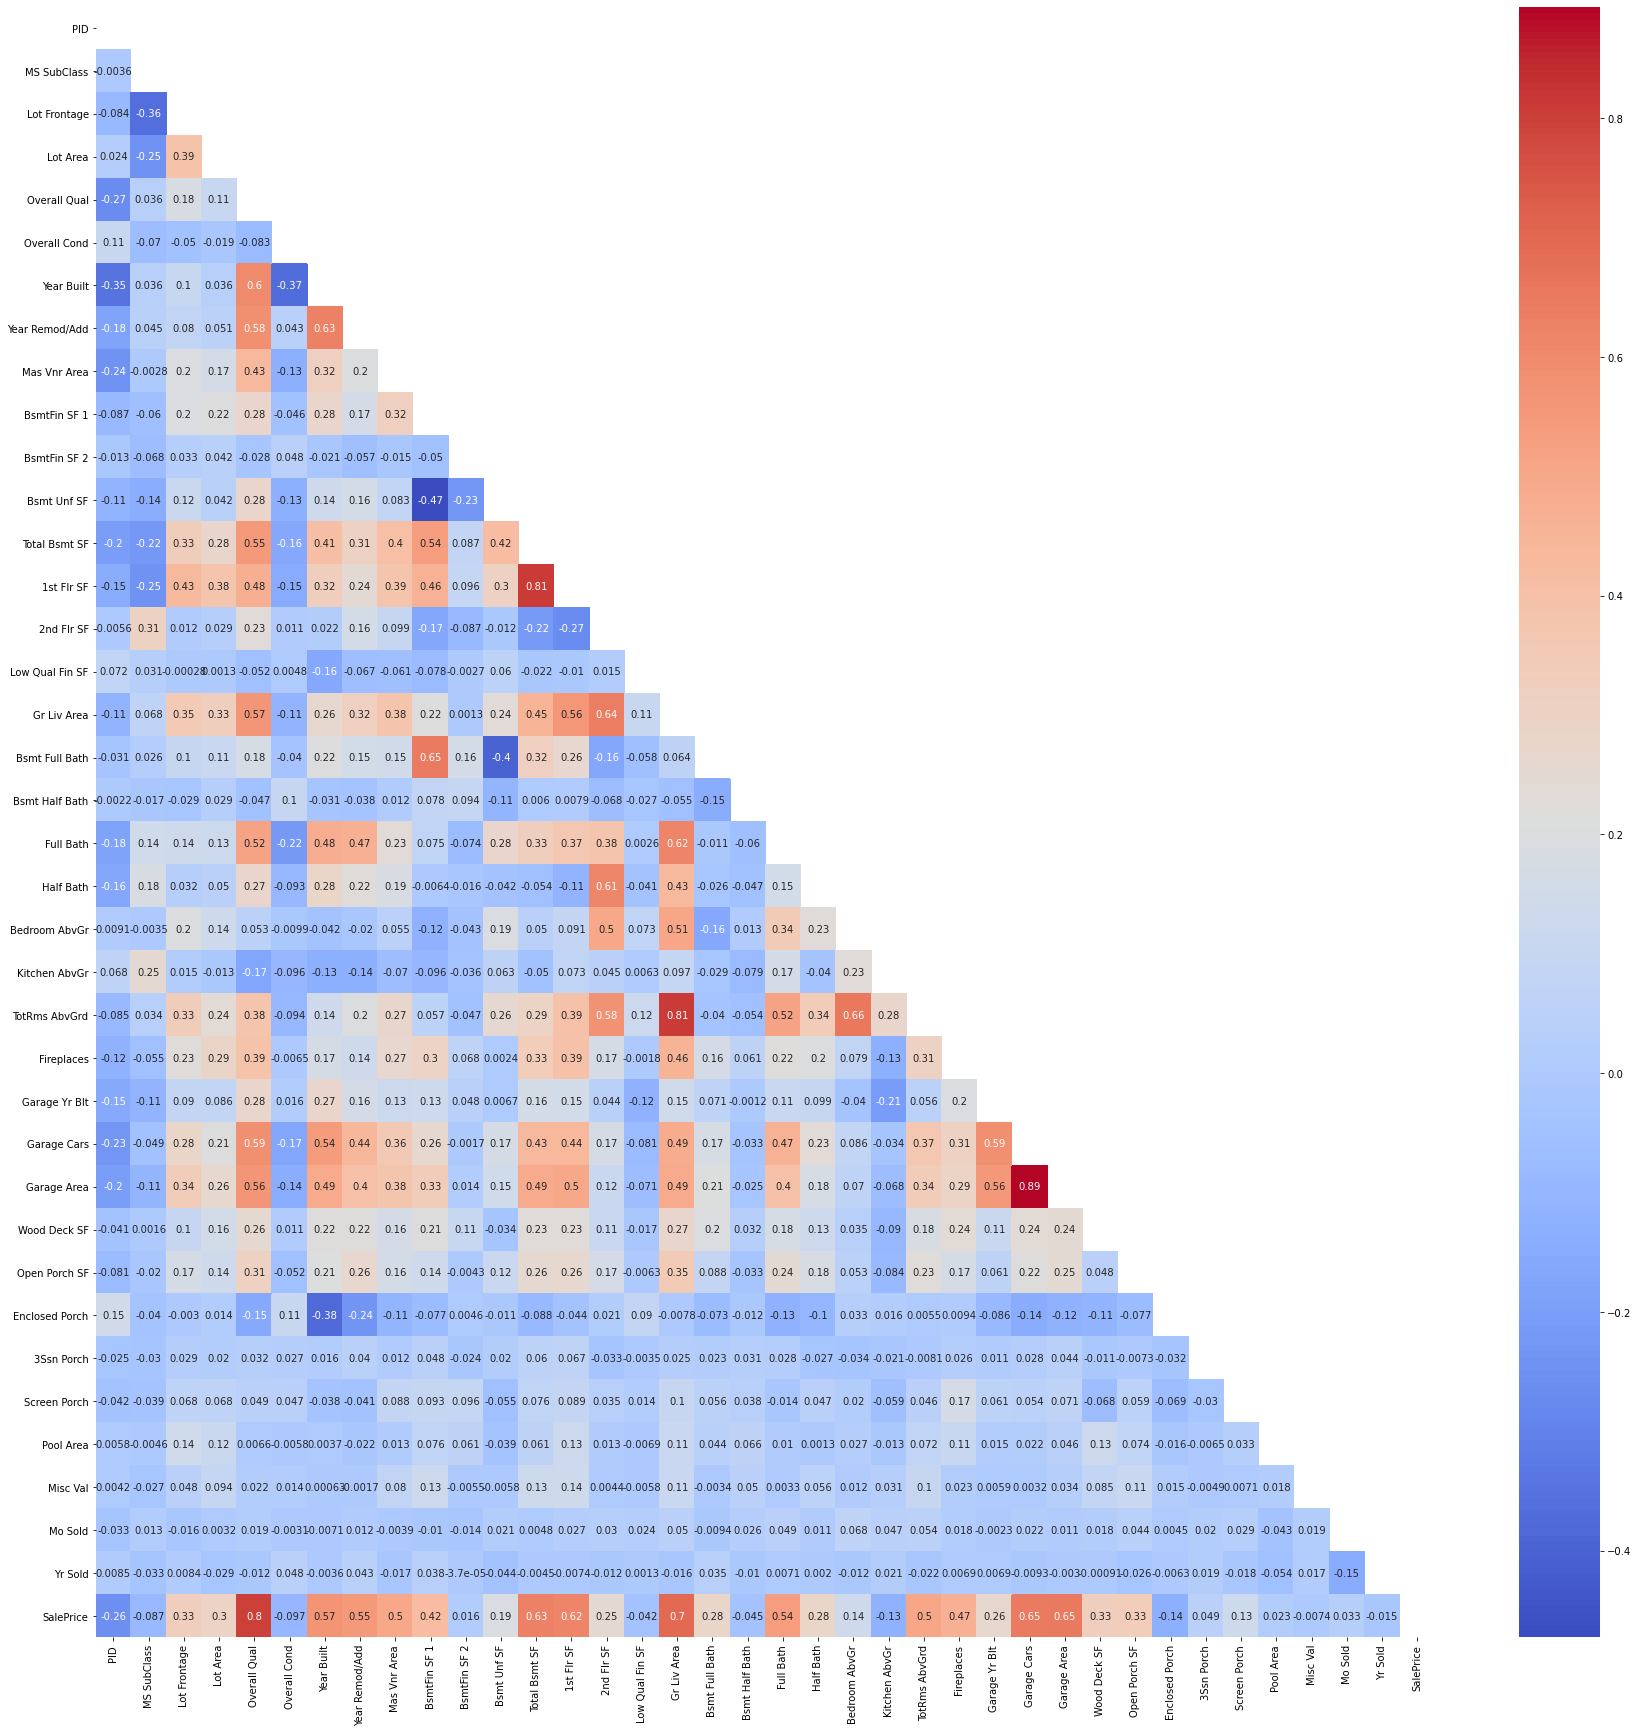

In [15]:
# Plot heatmap only for correlations where Pearson's r<>0
plt.figure(figsize=(30,30))
corr = train.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot = True, cmap='coolwarm')

### Findings from heatmap
`SalePrice` has a **strong** positive correlation with 
- `Overall Qual`
- `Gr Liv Area`

and a **moderately strong** positive correlation with
- `Year Built`
- `Year Remod/Add`
- `Mas Vnr Area`
- `BsmtFin SF1`
- `Total Bsmnt SF`
- `1st Flr SF`
- `Full Bath`
- `TotRms AbvGrd`
- `Fireplaces`
- `Garage Yr Blt`
- `Garage Cars`
- `Garage Area`

These features are likely to be strong predictors of `SalePrice`. 

## EDA: Scatterplot using Seaborn's `pairplot()`
In this section we will plot scatterplots to visualise the correlation between sale price and some of the stronger numeric predictors as found in the heatmap section. 

In [16]:
# Create a dataframe of Pearson's r correlation coeeff between SalePrice and all other predictors
corr_all = train.corr().loc[:,['SalePrice']]
corr_all.head()

,SalePrice
PID,-0.255052
MS SubClass,-0.087335
Lot Frontage,0.325850
Lot Area,0.296566
Overall Qual,0.800207


In [17]:
# Filter all predictors that where r>=0.5, not including SalePrice itself 
high_corr = corr_all[abs(corr_all['SalePrice'])>=0.5] # get all the predictors with r>=0.5
index = list(high_corr.index) # get a list of the indexes
index.remove('SalePrice') # remove SalePrice from the index
high_corr = high_corr.loc[index, :]
high_corr

,SalePrice
Overall Qual,0.800207
Year Built,0.571849
Year Remod/Add,0.550370
Mas Vnr Area,0.503579
Total Bsmt SF,0.629303
1st Flr SF,0.618486
Gr Liv Area,0.697038
Full Bath,0.537969
TotRms AbvGrd,0.504014
Garage Cars,0.647781


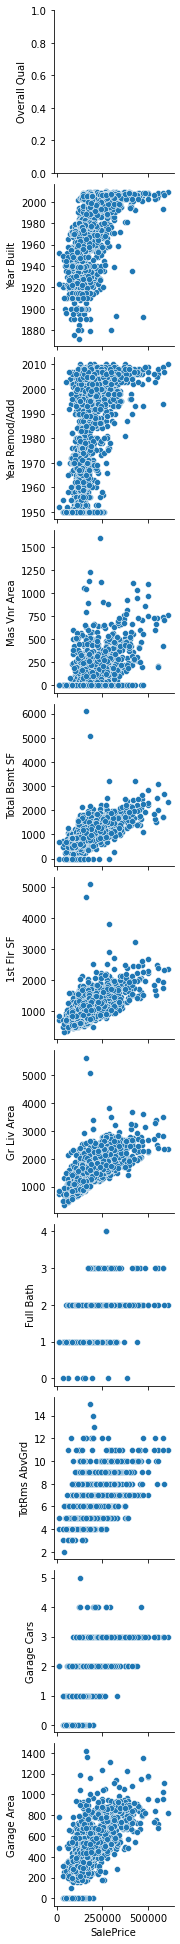

In [18]:
# Plotting the sns.pairplot

sns.pairplot(train, y_vars=high_corr.index, x_vars=['SalePrice'])

## EDA: Examining distributions

It looks like only `Overall Qual`, `Garage Area` and `SalePrice` have somewhat of a normal distribution. The other features are either left/right skewed or multimodal. 

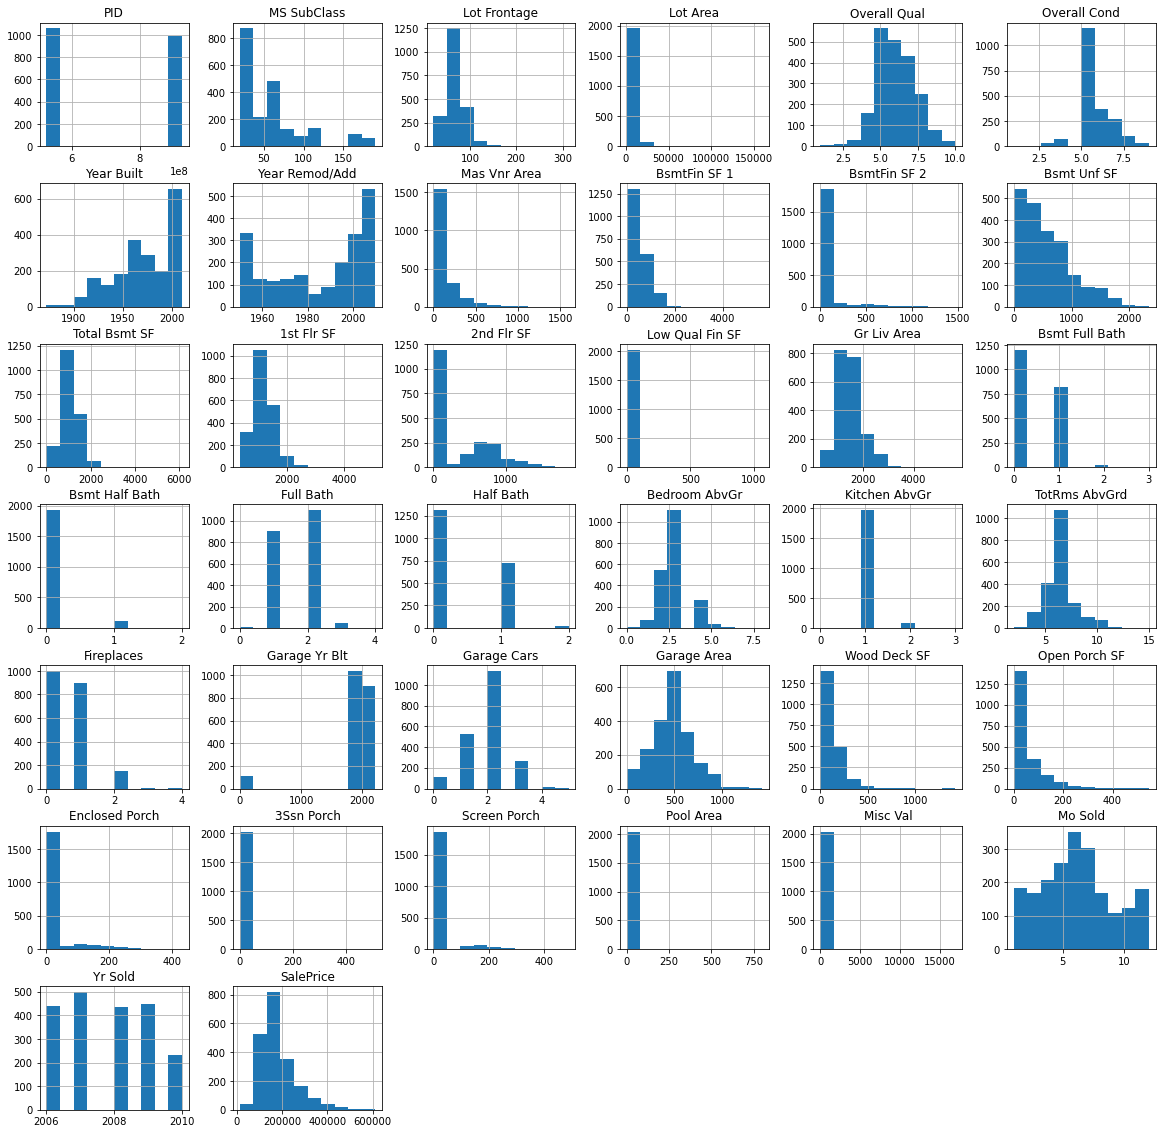

In [19]:
train.hist(figsize=(20, 20));

## EDA: Boxplot
Here, we shall check for outliers for our response variable `SalePrice`.

<function matplotlib.pyplot.show(close=None, block=None)>

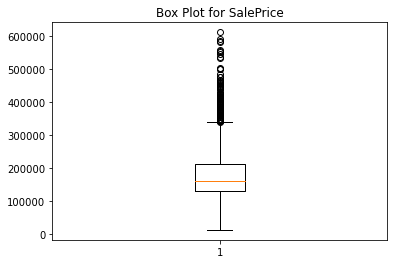

In [20]:
plt.boxplot(train['SalePrice'])
plt.title('Box Plot for SalePrice')
plt.show

### Findings from boxplot

There are quite a few outliers in `SalePrice` that could potentially cause our model to overfit, so let's drop the extreme datapoints that are at least 2 IQRs above the 75th percentile. 

In [21]:
pctl_75 = np.percentile(train['SalePrice'], 75)
pctl_25 = np.percentile(train['SalePrice'], 25)
IQR = pctl_75 - pctl_25

# List of indexes of outliers rows to be dropped 
drop_index = train[train['SalePrice']>=pctl_75+2*IQR].index.tolist()

In [22]:
# Drop outliers 
print(train.shape)
train.drop(index=drop_index, inplace=True)
print(train.shape)

(2051, 80)
(1991, 80)


## Model Prep: Prepare features `X` and response variable `y`

### Feature selection and engineering
The dataset has 78 features, not all of which are going to be useful. Including unnecessary features will create a lot of noise for the model which could result in overfitting. To drop some features, we will use the following methods.
1. Based on data definition
2. Pearson's R (for numeric data)
3. Create new features 

In [23]:
# Create a list of features to drop
drop_ft = ['SalePrice']

In [24]:
# 1: Based on data definition/information about the data set 

drop_ft.append('PID') # PID is a random identifier that will not be useful for prediction
drop_ft.append('Misc Feature') # >90% of rows in the dataset had missing values for this feature
drop_ft.append('Misc Val')

In [25]:
# 2: Get all the numeric features with an absolute value of Pearson's r<0.1 
low_corr = corr_all[abs(corr_all['SalePrice'])<0.1] 
drop_ft = drop_ft + low_corr.index.tolist()

In [26]:
# 3: Create new feature, age, which is the age of the house at time of sale
# This allows us to drop the datetime features 
train['Age'] = train['Yr Sold'] - train['Year Built']

drop_ft.append('Yr Sold')
drop_ft.append('Mo Sold')
drop_ft.append('Year Built')

In [27]:
drop_ft

['SalePrice',
 'PID',
 'Misc Feature',
 'Misc Val',
 'MS SubClass',
 'Overall Cond',
 'BsmtFin SF 2',
 'Low Qual Fin SF',
 'Bsmt Half Bath',
 '3Ssn Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'Yr Sold',
 'Mo Sold',
 'Year Built']

In [28]:
all_col = train.columns.tolist() # a list of all columns in train df 

keep_ft = list(set(all_col) - set(drop_ft))

In [29]:
# Get all numeric columns
num_col = train.select_dtypes(include=np.number).columns.tolist()

# Get all categoric columns
cat_col = set(train.columns.tolist()) - set(num_col)
cat_col = list(cat_col.intersection(set(keep_ft))) # only categoric columns that are to be kept

In [30]:
y = train['SalePrice']
X = train[keep_ft]
X = pd.get_dummies(data=X, columns=cat_col, drop_first=True) # dummify all categorical columns previously defined

In [31]:
X.head()

,Mas Vnr Area,Half Bath,Lot Frontage,2nd Flr SF,Gr Liv Area,Kitchen AbvGr,Bsmt Full Bath,Total Bsmt SF,Garage Yr Blt,1st Flr SF,...,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_missing_Garage Type,Street_Pave
Id,,,,,,,,,,,,,,,,,,,,,
109,289.0,1,69.0552,754,1479,1,0.0,725.0,1976.0,725,...,0,0,0,1,0,0,0,0,0,1
544,132.0,1,43.0000,1209,2122,1,1.0,913.0,1997.0,913,...,0,0,0,1,0,0,0,0,0,1
153,0.0,0,68.0000,0,1057,1,1.0,1057.0,1953.0,1057,...,0,0,0,0,0,0,0,1,0,1
318,0.0,1,73.0000,700,1444,1,0.0,384.0,2007.0,744,...,0,0,0,0,0,1,0,0,0,1
255,0.0,0,82.0000,614,1445,1,0.0,676.0,1957.0,831,...,0,0,0,0,0,0,0,1,0,1


In [32]:
X.shape

(1991, 247)

## Model Prep: Train/test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1493, 247)
(498, 247)


## Model Prep: Creating the Pipeline

In this pipeline, we first standardise our numeric variables using sklearn's `MinMaxScaler()` to scale our numeric columns to a value that is between 0 and 1 so that it is on the same scale as our categorical values.

Then, use `RFE()`, recursive feature engineering to select the features that are most relevant to our model. 

Finally, we apply the estimator (model). 


In [34]:
# Preparing steps and estimators
mms = MinMaxScaler()
models = [LinearRegression()
          , LassoCV(n_alphas=100)
          , RidgeCV(alphas=np.linspace(.1, 10, 100))]
# rfe = RFE(models[0], n_features_to_select=150)

# Pipeline flow: Scale variables to a 0-1 scale > Apply estimator 
lr = Pipeline([('linear', models[0])])
# lr1 = Pipeline([('rfe', rfe), ('linear', models[0])])
lr2 = Pipeline([('mms', mms), ('linear', models[0])])
# lr = Pipeline([('rfe', rfe0), ('linear', models[0])])
lasso = Pipeline([('scale', mms), ('lasso', models[1])])
ridge = Pipeline([('scale', mms), ('ridge', models[2])])

## Cross Validation

In [35]:
# Create 5 splits, shuffle the data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
lr_scores = cross_val_score(lr, X_train, y_train, cv=kf, n_jobs=-1)
# lr1_scores = cross_val_score(lr1, X_train, y_train, cv=kf, n_jobs=-1)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=kf, n_jobs=-1)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=kf, n_jobs=-1)

print(f"lr: {lr_scores.mean()}")
print(f"lasso: {lasso_scores.mean()}")
print(f"ridge: {ridge_scores.mean()}")

lr: 0.8202186389441992
lasso: 0.8477573341697108
ridge: 0.8461291847734449


## Model Fitting and Evaluation

Based on cross validation scores, Lasso and Ridge models performed the best so we shall go ahead to fit and test these two models. Based on test R2 and RMSE, Lasso regression performed better so this would be the best model to go ahead with. 

Considering that the dataset has many features, it makes sense that Lasso regression performed the best as it is able to deal with datasets with many features better it 'zeroes out' the coefficients of features due to its penalty term. 

In [37]:
# Fit and get R2 and RMSE scores for lasso

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print(f"train R2 score: {lasso.score(X_train, y_train)}")
print(f"test R2 score: {lasso.score(X_test, y_test)}")
print(f"test RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

train R2 score: 0.8923112926325375
test R2 score: 0.8932348955719065
test RMSE: 20665.606716575112


In [38]:
# Fit and get R2 and RMSE scores for ridge

ridge.fit(X_train, y_train)
y_pred2 = ridge.predict(X_test)

print(f"train R2 score: {ridge.score(X_train, y_train)}")
print(f"test R2 score: {ridge.score(X_test, y_test)}")
print(f"test RMSE: {mean_squared_error(y_test, y_pred2)**0.5}")

train R2 score: 0.8932156135677453
test R2 score: 0.8825494185770092
test RMSE: 21675.098566027427


In [39]:
# Compare with null model: Both lasso and ridge regression have a lower RMSE than the null model (phew) 

y_bar = np.full(y_test.shape[0], train['SalePrice'].mean()) # create a np array for null model
print(f"null RMSE: {mean_squared_error(y_test, y_bar, squared=False)}")

null RMSE: 63265.18978847254


In [40]:
# Create df for coefficients of Lasso regression model
features = pd.DataFrame(X_train.columns, columns=['features'])
features['coeff'] = lasso.named_steps['lasso'].coef_

In [41]:
# Top 10 positive predictors
features.sort_values('coeff', ascending=False).head(10)

,features,coeff
4,Gr Liv Area,145198.989086
13,Overall Qual,90211.673874
190,Neighborhood_GrnHill,39877.951965
18,Garage Cars,39665.263622
199,Neighborhood_NridgHt,33634.545635
198,Neighborhood_NoRidge,29383.281736
6,Bsmt Full Bath,26088.635948
204,Neighborhood_Somerst,20538.811816
23,Full Bath,19273.952047
21,Screen Porch,18086.219948


In [42]:
# Top 10 negative predictors 
features.sort_values('coeff').head(10)

,features,coeff
31,Bldg Type_Twnhs,-27337.364662
125,Kitchen Qual_Fa,-25461.616779
127,Kitchen Qual_TA,-23361.935579
32,Bldg Type_TwnhsE,-19779.167561
126,Kitchen Qual_Gd,-17997.265062
27,Lot Shape_IR3,-12431.090518
187,Neighborhood_Edwards,-11835.047234
68,Bsmt Qual_Gd,-11659.848227
70,Bsmt Qual_TA,-10871.117269
51,BsmtFin Type 1_missing_BsmtFin Type 1,-10627.975594


## Conclusion and findings

Based on the Lasso regression model, the strongest positive predictors of `SalePrice` are 
- `Gr Liv Area`: Above grade (ground) living area square feet 
- `Overall Qual`:  Rating of the overall material and finish of the house
- The type of neighbourhood the house is located in 
- `Garage Cars`: Size of garage in car capacity 
- `Bsmt Full Bath`: The number of full bathrooms in the basement 
- `Full Bath`: The number of full bathrooms above ground
- `Screen Porch`: Screen porch area in square feet

The strongest negative predictors of `SalePrice` are 
- Building type (whether or not the house is townhouse)
- Kitchen quality
- Lot shape (whether the lot is irregular shaped)
- Whether the house is located in the Edwards neighborhood

Our agents can use this information to get estimate a price for each house and ensure that our customers sell their house at a good market price. In addition, based on this information, our company can start collecting this data on the houses we sell to start our own database for future predictions.

## Limitations of the model 
However, as with every model, this model has limitations as well. 

1. Assumption of linearity between the response variable, `SalePrice`, and the features. Real world data like the Ames housing dataset rarely has a straight-line relationship between the dependent and independent variables. 

2. In reality, there can be many outliers for `SalePrice` and the model would not be able to predict the prices of such outliers accurately since outliers are removed when training the model. 

3. This model is specific to Ames and may not be useful to predict house prices in other towns. 

## Using Model to Predict `SalePrice` for Test Data

### Data Prep: Clean Up Missing Values

In [43]:
# Check null values
null_val = pd.DataFrame(test.isna().sum()/test.shape[0]).reset_index()
null_val.columns = ['feature', 'null_%']
null_val[null_val['null_%']>0]

,feature,null_%
3,Lot Frontage,0.182232
6,Alley,0.933941
25,Mas Vnr Type,0.001139
26,Mas Vnr Area,0.001139
30,Bsmt Qual,0.028474
31,Bsmt Cond,0.028474
32,Bsmt Exposure,0.028474
33,BsmtFin Type 1,0.028474
35,BsmtFin Type 2,0.028474
42,Electrical,0.001139


In [44]:
# Missing data processing pt1, replacing missing values with 'missing feature'
missing_lst_col(no_ft_col, df=test)

In [45]:
# Check null values
# Check that data has been filled 
null_val = pd.DataFrame(test.isna().sum()/test.shape[0]).reset_index()
null_val.columns = ['feature', 'null_%']
null_val[null_val['null_%']>0]

,feature,null_%
3,Lot Frontage,0.182232
26,Mas Vnr Area,0.001139
42,Electrical,0.001139
59,Garage Yr Blt,0.051253


In [46]:
# Missing data processing for `Mas Vnr Area` and `Garage Yr Blt`
test['Mas Vnr Area'] = test['Mas Vnr Area'].fillna(0)
test['Garage Yr Blt'] = test['Garage Yr Blt'].fillna(0)

In [47]:
# Impute mean value for `Lot Frontage`

test['Lot Frontage'] = test['Lot Frontage'].fillna(test['Lot Frontage'].mean())

In [48]:
# Check missing data all filled
null_val = pd.DataFrame(test.isna().sum()/test.shape[0]).reset_index()
null_val.columns = ['feature', 'null_%']
null_val[null_val['null_%']>0]

,feature,null_%
42,Electrical,0.001139


In [49]:
# Create feature `Age`
test['Age'] = test['Yr Sold'] - test['Year Built']

In [50]:
X_test_data = test[keep_ft]
print(X_test_data.shape)
X_test_data = pd.get_dummies(data=X_test_data, columns=cat_col, drop_first=True) # dummify all categorical columns previously defined
print(X_test_data.shape)
# X_test = X_test[X.columns.tolist()]
# print(X_test.shape)

(878, 67)
(878, 230)


In [51]:
# Features in model fit that are not in test data 
miss_ft = set(X_train.columns) - set(X_test_data.columns)

In [52]:
# Add missing features 

for ft in miss_ft: 
    X_test_data[ft] = np.zeros_like(X_test_data['Lot Area'])

In [53]:
# Features in test data that were unseen in model fit 

extra_ft = set(X_test_data.columns) - set(X_train.columns)
extra_ft

{'Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Heating_GasA',
 'Kitchen Qual_Po',
 'Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Sale Type_VWD'}

In [54]:
# Remove extra features 

X_test_data.drop(columns=list(extra_ft), inplace=True)

In [55]:
y_pred = lasso.predict(X_test_data)
X_test_data['SalePrice']=y_pred

In [56]:
submission = X_test_data[['SalePrice']].to_csv('./datasets/submission_1.csv')